## Adding packages.

In [30]:
using Pkg;

# packages to install, first time can take a while downloading, please be patient ...
packages=["HTTP","JSON","DataFrames","Plots","StatPlots","PlotThemes","GR","PyPlot","PyCall","LaTeXStrings","Plotly","PlotlyJS"]

for package in packages
    if get(Pkg.installed(),package,-1) == -1
        println(" getting package : ", package)
        Pkg.add(package)
    end
end

## creating generic functions for Binance API data retrieval

In [31]:
# show all data for a given value
function showAll(value)
    show(IOContext(stdout, :displaysize => (10^6, 10^6)), "text/plain", value)
end

using HTTP, JSON, Dates
import Printf.@sprintf

# base URL of the Binance API
const BINANCE_API_REST = "https://api.binance.com/api/v1/ticker/";

# function HTTP response 2 JSON
function r2j(response)
    JSON.parse(String(response))
end

# retrieve data from binance for "allPrices", "24hr", "allBookTickers"
function getBinanceDataFor(withSubject)
    r = HTTP.request("GET", string(BINANCE_API_REST, withSubject))
    r2j(r.body)
end

# current Binance market
function getBinanceMarket()
    r = HTTP.request("GET", "https://www.binance.com/exchange/public/product")
    r2j(r.body)["data"]
end

# binance get candlesticks/klines data
function getBinanceKline(symbol, startDateTime, endDateTime ; interval="1m")
    startTime = @sprintf("%.0d",Dates.datetime2unix(startDateTime) * 1000)
    endTime = @sprintf("%.0d",Dates.datetime2unix(endDateTime) * 1000)
    query = string("symbol=", symbol, "&interval=", interval, "&startTime=", startTime, "&endTime=", endTime) 
    r = HTTP.request("GET", string("https://api.binance.com/api/v1/klines?",  query))
    r2j(r.body)
end

# getFloatValueArray
getFloatValueArray(withKey, withDictArr) = map(dict -> parse(Float32, dict[withKey]) ,withDictArr)
getStringValueArray(withKey, withDictArr) = map(dict -> convert(String, dict[withKey]) ,withDictArr)
# filter 
filterOnRegex(matcher,withDictArr; withKey="symbol") = filter(x-> match(Regex(matcher), x[withKey]) != nothing, withDictArr)

filterOnRegex (generic function with 1 method)

In [32]:
# get 24H tickerdata of all assets
hr24 = getBinanceDataFor("24hr");
# base currencies substract retrieve last 3 symbols USDT wil get mangled :-|
basecurrences = unique(map(x->x["symbol"][end-2:end],hr24));
# all symbols currently on the market
allSymbols = map(x->x["symbol"],hr24);


In [33]:
# lets convert JSON data to Dataframes 

In [34]:
using DataFrames;

symbols = map(x->x["symbol"],hr24);

println("\n Binance is currently trading in ", size(symbols,1)," assets.")
# show first entry of hr24 symbol list so see what is init
println("\n example value from 1 entry in our hr24  \n\n")
showAll(melt(DataFrame(hr24[1]),:symbol))


symbols = getStringValueArray("symbol", hr24);
basesymbols = map(x->x["symbol"][end-2:end],hr24);
lastPrice = getFloatValueArray("lastPrice", hr24);
priceChangePercent = getFloatValueArray("priceChangePercent", hr24);

# volume BTC ammount = volume * weightedAvgPrice
quoteVolume = getFloatValueArray("quoteVolume", hr24);
volume = getFloatValueArray("volume", hr24);
# Dataframe convenient structure to handle data in tabular format
df = DataFrame(basesymbol=basesymbols, symbol=symbols, lastPrice=lastPrice, priceChangePercent=priceChangePercent, quoteVolume=quoteVolume, volume=volume);
sort!(df, :priceChangePercent; rev=false);


 Binance is currently trading in 389 assets.

 example value from 1 entry in our hr24  


20×3 DataFrame
│ Row │ variable           │ value           │ symbol │
├─────┼────────────────────┼─────────────────┼────────┤
│ 1   │ askPrice           │ 0.03979200      │ ETHBTC │
│ 2   │ askQty             │ 29.56700000     │ ETHBTC │
│ 3   │ bidPrice           │ 0.03978100      │ ETHBTC │
│ 4   │ bidQty             │ 1.57500000      │ ETHBTC │
│ 5   │ closeTime          │ 1536000383743   │ ETHBTC │
│ 6   │ count              │ 120729          │ ETHBTC │
│ 7   │ firstId            │ 80132739        │ ETHBTC │
│ 8   │ highPrice          │ 0.04053200      │ ETHBTC │
│ 9   │ lastId             │ 80253467        │ ETHBTC │
│ 10  │ lastPrice          │ 0.03979200      │ ETHBTC │
│ 11  │ lastQty            │ 0.15900000      │ ETHBTC │
│ 12  │ lowPrice           │ 0.03953700      │ ETHBTC │
│ 13  │ openPrice          │ 0.04040500      │ ETHBTC │
│ 14  │ openTime           │ 1535913983743   │ ETHBTC 

In [35]:
# get only symbols ending on BTC
hr24BTC = filterOnRegex("BTC\$", hr24)
hr24ETH = filterOnRegex("ETH\$", hr24)
hr24BNB = filterOnRegex("BNB\$", hr24)
hr24USDT = filterOnRegex("USDT\$", hr24)

println("BTC has : ",size(hr24ETH,1)," assets")
println("ETH has : ",size(hr24BTC,1)," assets")
println("BNB has : ",size(hr24BNB,1)," assets")
println("USDT has : ",size(hr24USDT,1)," assets")

BTC has : 145 assets
ETH has : 148 assets
BNB has : 76 assets
USDT has : 20 assets


In [36]:
# get the latest currency values from base currencies
fdf = filter(row -> row[:symbol] in ["BTCUSDT","ETHUSDT","BNBUSDT"], df)
results = (fdf[:,[:symbol,:lastPrice]])
append!(results,DataFrame(symbol=["SDTUSDT"],lastPrice = [1.0]))
println("\n Get the \$ values from the base currencies\n")
unique!(results)


 Get the $ values from the base currencies



,symbol,lastPrice
1,ETHUSDT,289.72
2,BTCUSDT,7282.26
3,BNBUSDT,11.3001
4,SDTUSDT,1.0


4×4 DataFrame
│ Row │ basesymbol │ assetSize │ quoteVolume │ quoteVolumeUSDT │
├─────┼────────────┼───────────┼─────────────┼─────────────────┤
│ 1   │ BTC        │ 148       │ 50927.3     │ 370.866         │
│ 2   │ ETH        │ 145       │ 1.47129e5   │ 42.6261         │
│ 3   │ BNB        │ 76        │ 2.17332e5   │ 2.45587         │
│ 4   │ SDT        │ 20        │ 5.52313e8   │ 552.313         │

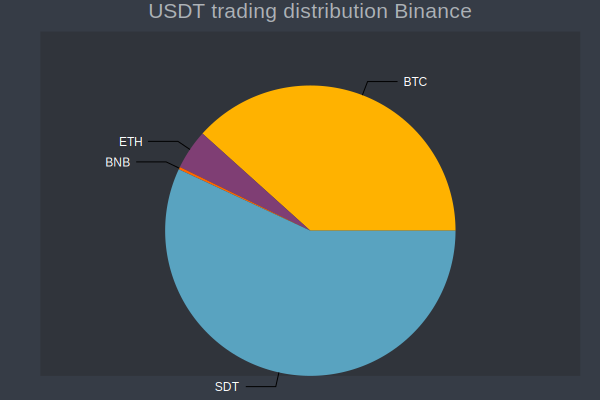

In [37]:
using StatPlots
theme(:dark);

symbol_volume = by(df, :basesymbol) do d
    USDT_CONVERSION = filter(row -> row[:symbol] == string(d[:basesymbol][1], "USDT"), results)[:lastPrice]
    DataFrame(assetSize  = size(d[:symbol], 1), quoteVolume  = sum(d[:quoteVolume]), quoteVolumeUSDT  = sum(d[:quoteVolume])*USDT_CONVERSION/10^6)
    end;

show(sort!(symbol_volume, [:assetSize,:quoteVolumeUSDT]; rev=true))

Plots.plot(symbol_volume[:basesymbol], symbol_volume[:quoteVolumeUSDT],seriestype=:pie,title = "USDT trading distribution Binance")